In [1]:
#loading in adjusted array 


In [1]:
import numpy as np 
df = np.load('/content/drive/MyDrive/Colab Notebooks/final_array.npy')

In [2]:
#checking shape of array 
df.shape

(2730, 5, 280, 280, 1)

**load in first 2500 images and bring in cancer and benign list**

In [3]:
#making cancer and benign list 
cancer_list = [3 for _ in range(82)]
#making benign list
benign_list = [2 for _ in range(148)]
combined_list = cancer_list + benign_list
combined_list[229]

2

In [4]:
#loading in the labels df 
import pandas as pd 
label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Labels.csv")

In [5]:
#one hot encoding into one column 
label.loc[label['Normal'] == 1, 'one_hot_encoded_col'] = 0
label.loc[label['Actionable'] == 1, 'one_hot_encoded_col'] = 1
label.loc[label['Benign'] == 1, 'one_hot_encoded_col'] = 2
label.loc[label['Cancer'] == 1, 'one_hot_encoded_col'] = 3

# display the resulting dataframe
print(label)

       PatientID    StudyUID  View  Normal  Actionable  Benign  Cancer  \
0     DBT-P00023  DBT-S04378  lmlo       0           1       0       0   
1     DBT-P00023  DBT-S04378  rmlo       0           1       0       0   
2     DBT-P00029  DBT-S00044  lmlo       1           0       0       0   
3     DBT-P00029  DBT-S00044  rmlo       1           0       0       0   
4     DBT-P00032  DBT-S04706  lmlo       1           0       0       0   
...          ...         ...   ...     ...         ...     ...     ...   
9483  DBT-P02569  DBT-S01802  rmlo       1           0       0       0   
9484  DBT-P04356  DBT-S00073  lmlo       1           0       0       0   
9485  DBT-P04356  DBT-S00073  rmlo       1           0       0       0   
9486  DBT-P01481  DBT-S01753  lmlo       1           0       0       0   
9487  DBT-P01481  DBT-S01753  rmlo       1           0       0       0   

      one_hot_encoded_col  
0                     1.0  
1                     1.0  
2                     0.0  

In [6]:
#making list of the one hote encoded collumn 
#making list of first 3000 observations 
one_hot_encoded_list = label.iloc[:2500]['one_hot_encoded_col'].tolist()

In [7]:
one_hot_encoded_list = combined_list + one_hot_encoded_list

In [8]:
#checking length of list 
len(one_hot_encoded_list)

2730

In [9]:
from collections import Counter

one_hot_encoded_counts = Counter(one_hot_encoded_list)
print(one_hot_encoded_counts)

Counter({0.0: 2128, 1.0: 358, 2: 158, 3: 86})


**Untuned modeel**

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16

if tf.test.is_gpu_available():
    print('GPU available:')
    for gpu in tf.config.list_physical_devices('GPU'):
        print(gpu)
    tf.config.set_visible_devices(gpu, 'GPU')
else:
    print('No GPU available.')

dicom_array = df
labels = one_hot_encoded_list
dicom_array = np.repeat(dicom_array, 3, axis=-1)

labels = np.asarray(labels)
labels = labels.astype(np.int32)
num_classes = np.max(labels) + 1
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    dicom_array, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)

input_shape = (5, 280, 280, 3)

# Load the VGG-16 model
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape[1:]
)

for layer in base_model.layers:
    layer.trainable = True

input_layer = layers.Input(shape=input_shape, name="input")
x = layers.TimeDistributed(base_model)(input_layer)
x = layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(num_classes, activation='softmax', name="output")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2)






Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5, 280, 280, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 8, 8, 512)     14714688  
 ibuted)                                                         
                                                                 
 conv3d (Conv3D)             (None, 5, 8, 8, 64)       294976    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 4, 4, 64)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 4, 4, 64

analysing performance of unntuned model 

18/18 [==============================] - 8s 175ms/step
Overall Accuracy: 0.78
Overall Sensitivity: 0.44
Overall Specificity: 0.79
Overall F1-score: 0.48


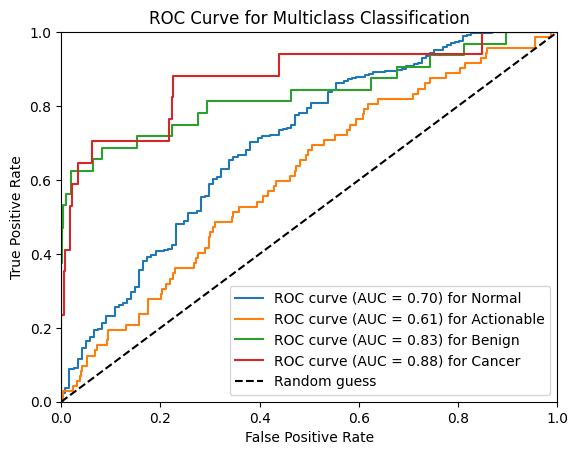

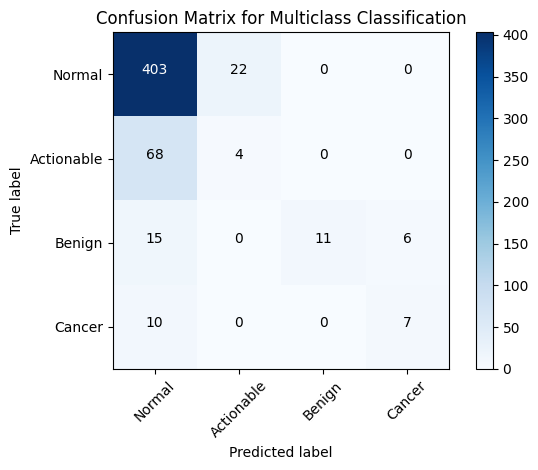

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Generate predictions
y_pred = model.predict(X_test)

# Calculate AUC-ROC score
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Calculate confusion matrix
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate sensitivity and specificity for each class
num_classes = y_test.shape[1]
sensitivity = []
specificity = []
for i in range(num_classes):
    true_positives = cm[i,i]
    false_positives = cm[:,i].sum() - true_positives
    false_negatives = cm[i,:].sum() - true_positives
    true_negatives = cm.sum() - true_positives - false_positives - false_negatives
    
    sensitivity.append(true_positives / (true_positives + false_negatives))
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate overall accuracy, sensitivity, specificity, and F1-score
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
overall_f1_score = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.2f}')
print(f'Overall Sensitivity: {overall_sensitivity:.2f}')
print(f'Overall Specificity: {overall_specificity:.2f}')
print(f'Overall F1-score: {overall_f1_score:.2f}')

# Plot ROC curve
class_names = ['Normal', 'Actionable', 'Benign', 'Cancer']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")

plt.show()

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Multiclass Classification')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()


In [14]:
print(sensitivity)

[0.9482352941176471, 0.05555555555555555, 0.34375, 0.4117647058823529]


In [13]:
print(specificity)

[0.23140495867768596, 0.9535864978902954, 1.0, 0.9886578449905482]


**bold text**

Tuned model 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

if tf.test.is_gpu_available():
    print('GPU available:')
    for gpu in tf.config.list_physical_devices('GPU'):
        print(gpu)
    tf.config.set_visible_devices(gpu, 'GPU')
else:
    print('No GPU available.')

dicom_array = df
labels = one_hot_encoded_list
dicom_array = np.repeat(dicom_array, 3, axis=-1)

labels = np.asarray(labels)
labels = labels.astype(np.int32)
num_classes = np.max(labels) + 1
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    dicom_array, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)
def create_model(learning_rate=1e-5, dropout_rate=0.3):
    input_shape = (5, 280, 280, 3)

    # Load the VGG-16 model
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape[1:]
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Custom model to handle the 5D input
    input_layer = layers.Input(shape=input_shape, name="input")
    x = layers.TimeDistributed(base_model)(input_layer)
    x = layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax', name="output")(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=8, verbose=1)

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.3, 0.4, 0.5]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the model with Grid Search
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train the model with the best hyperparameters on the entire training set
best_learning_rate = grid_result.best_params_['learning_rate']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_model = create_model(learning_rate=best_learning_rate, dropout_rate=best_dropout_rate)
best_model.fit(X_train, y_train, epochs=10, batch_size=8)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<ipython-input-11-e1f0127ac525>:62: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=8, verbose=1)


18/18 [==============================] - 8s 174ms/step
Overall Accuracy: 0.76
Overall Sensitivity: 0.48
Overall Specificity: 0.81
Overall F1-score: 0.53


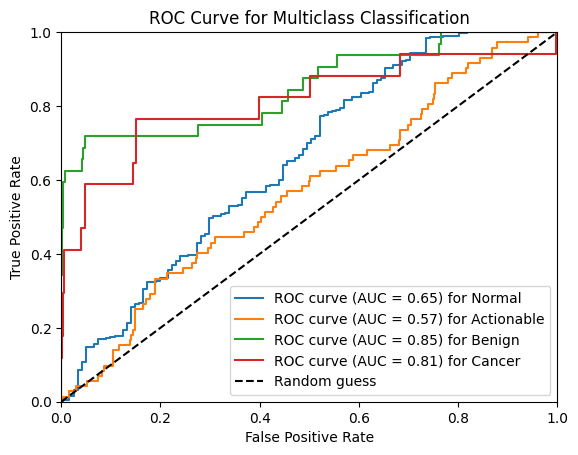

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

num_classes = y_test.shape[1]
sensitivity = []
specificity = []
for i in range(num_classes):
    true_positives = cm[i,i]
    false_positives = cm[:,i].sum() - true_positives
    false_negatives = cm[i,:].sum() - true_positives
    true_negatives = cm.sum() - true_positives - false_positives - false_negatives
    
    sensitivity.append(true_positives / (true_positives + false_negatives))
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate overall accuracy, sensitivity, specificity, and F1-score
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
overall_f1_score = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.2f}')
print(f'Overall Sensitivity: {overall_sensitivity:.2f}')
print(f'Overall Specificity: {overall_specificity:.2f}')
print(f'Overall F1-score: {overall_f1_score:.2f}')

class_names = ['Normal', 'Actionable', 'Benign', 'Cancer']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")

plt.show()

